📊 Generating embeddings and creating train/test split...
✅ Saved embeddings for 4 people
✅ Test set contains 21 images

🔍 Evaluating face recognition performance...

📊 Performance Metrics:
Overall Accuracy: 0.9524
Micro-averaged Precision: 0.9524
Micro-averaged Recall: 0.9524
Micro-averaged F1 Score: 0.9524
Weighted Precision: 1.0000
Weighted Recall: 0.9524
Weighted F1 Score: 0.9735
✅ Confusion matrix saved to confusion_matrix.png
✅ Detailed metrics saved to metrics.json

✅ Face recognition system processing completed!


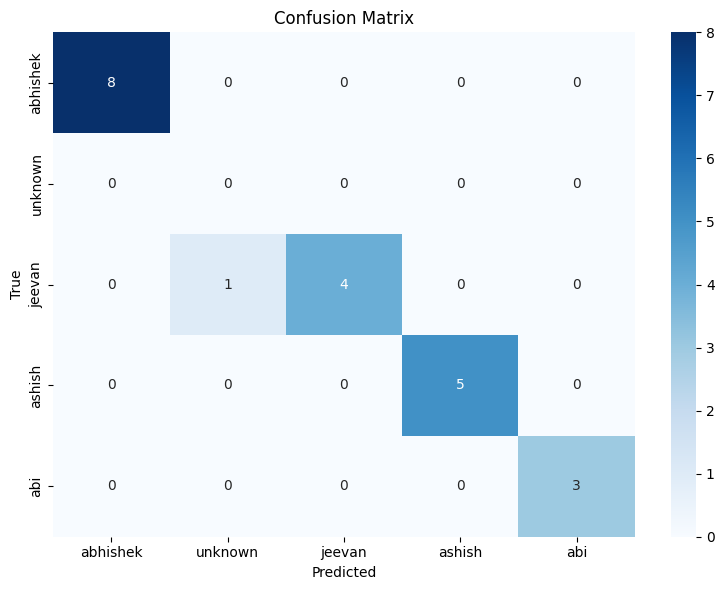

In [2]:
import os
import torch
import json
import numpy as np
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
face_detector = MTCNN(keep_all=False, device=device)
face_encoder = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Path to faces folder
faces_dir = r"C:\Users\abhi1\Desktop\BIOMETRIC\dataa\faces"
embeddings_dict = {}

# Threshold for face recognition (cosine similarity)
SIMILARITY_THRESHOLD = 0.7

# Function to compute cosine similarity
def cosine_similarity(embedding1, embedding2):
    return np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))

# Ensure faces directory exists
if not os.path.exists(faces_dir):
    print("❌ Faces directory not found!")
    exit()

# Split data into training (80%) and testing (20%)
person_folders = [f for f in os.listdir(faces_dir) if os.path.isdir(os.path.join(faces_dir, f))]
train_data = {}
test_data = []

# Create train/test split and generate embeddings
print("📊 Generating embeddings and creating train/test split...")
for person_name in person_folders:
    person_folder = os.path.join(faces_dir, person_name)
    
    if os.path.isdir(person_folder):
        embeddings = []
        test_images = []
        
        # Get all valid image files
        img_files = [f for f in os.listdir(person_folder) if f.endswith((".jpg", ".png"))]
        
        if not img_files:
            print(f"⚠️ No images found for {person_name}, skipping...")
            continue
            
        # Split into train/test
        train_count = max(1, int(len(img_files) * 0.8))
        
        # Process training images
        for img_name in img_files[:train_count]:
            img_path = os.path.join(person_folder, img_name)
            img = Image.open(img_path).convert("RGB")
            
            # Detect and encode face
            face = face_detector(img)
            if face is None:
                print(f"⚠️ No face detected in {img_name}, skipping...")
                continue
                
            face = face.unsqueeze(0).to(device)
            embedding = face_encoder(face).detach().cpu().numpy().flatten()
            embeddings.append(embedding)
        
        # Add test images to test set
        for img_name in img_files[train_count:]:
            img_path = os.path.join(person_folder, img_name)
            test_images.append((img_path, person_name))
            
        # Store average embedding for training data
        if embeddings:
            train_data[person_name] = np.mean(embeddings, axis=0)
        else:
            print(f"⚠️ No valid embeddings for {person_name}, skipping...")
            
        # Add test images to test data
        test_data.extend(test_images)

# Save embeddings to JSON (only training data)
embeddings_dict = {name: embedding.tolist() for name, embedding in train_data.items()}
os.makedirs(os.path.dirname(r"C:\Users\abhi1\Desktop\BIOMETRIC\scripts\dataa\embeddings.json"), exist_ok=True)
with open(r"C:\Users\abhi1\Desktop\BIOMETRIC\scripts\dataa\embeddings.json", "w") as f:
    json.dump(embeddings_dict, f, indent=4)

print(f"✅ Saved embeddings for {len(train_data)} people")
print(f"✅ Test set contains {len(test_data)} images")

# Evaluate on test set
if test_data:
    print("\n🔍 Evaluating face recognition performance...")
    
    y_true = []
    y_pred = []
    confidences = []
    
    for img_path, true_label in test_data:
        img = Image.open(img_path).convert("RGB")
        
        # Detect face
        face = face_detector(img)
        if face is None:
            print(f"⚠️ No face detected in test image {os.path.basename(img_path)}, skipping...")
            continue
            
        # Encode face
        face = face.unsqueeze(0).to(device)
        test_embedding = face_encoder(face).detach().cpu().numpy().flatten()
        
        # Find closest match
        max_similarity = -1
        predicted_label = "unknown"
        
        for name, stored_embedding in train_data.items():
            similarity = cosine_similarity(test_embedding, stored_embedding)
            if similarity > max_similarity:
                max_similarity = similarity
                predicted_label = name
        
        # Check if similarity is above threshold
        if max_similarity < SIMILARITY_THRESHOLD:
            predicted_label = "unknown"
        
        y_true.append(true_label)
        y_pred.append(predicted_label)
        confidences.append(max_similarity)
    
    # Calculate metrics
    if y_true:
        # Accuracy
        accuracy = accuracy_score(y_true, y_pred)
        
        # Precision, recall, and F1 score (micro averaged)
        precision = precision_score(y_true, y_pred, average='micro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='micro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
        
        # Precision, recall, and F1 score (weighted)
        precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        # Generate confusion matrix
        labels = list(set(y_true + y_pred))
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        
        # Calculate per-class metrics
        class_metrics = {}
        for i, label in enumerate(labels):
            true_positives = cm[i, i]
            false_positives = cm[:, i].sum() - true_positives
            false_negatives = cm[i, :].sum() - true_positives
            
            class_precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
            class_recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
            class_f1 = 2 * (class_precision * class_recall) / (class_precision + class_recall) if (class_precision + class_recall) > 0 else 0
            
            class_metrics[label] = {
                "precision": class_precision,
                "recall": class_recall,
                "f1": class_f1
            }
        
        # Print metrics
        print("\n📊 Performance Metrics:")
        print(f"Overall Accuracy: {accuracy:.4f}")
        print(f"Micro-averaged Precision: {precision:.4f}")
        print(f"Micro-averaged Recall: {recall:.4f}")
        print(f"Micro-averaged F1 Score: {f1:.4f}")
        print(f"Weighted Precision: {precision_weighted:.4f}")
        print(f"Weighted Recall: {recall_weighted:.4f}")
        print(f"Weighted F1 Score: {f1_weighted:.4f}")
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig(r"C:\Users\abhi1\Desktop\BIOMETRIC\scripts\dataa\confusion_matrix.png")
        print(f"✅ Confusion matrix saved to confusion_matrix.png")
        
        # Save metrics to JSON
        metrics_data = {
            "overall": {
                "accuracy": accuracy,
                "precision_micro": precision,
                "recall_micro": recall,
                "f1_micro": f1,
                "precision_weighted": precision_weighted,
                "recall_weighted": recall_weighted,
                "f1_weighted": f1_weighted,
                "similarity_threshold": SIMILARITY_THRESHOLD
            },
            "per_class": class_metrics
        }
        
        with open(r"C:\Users\abhi1\Desktop\BIOMETRIC\scripts\dataa\metrics.json", "w") as f:
            json.dump(metrics_data, f, indent=4)
        
        print(f"✅ Detailed metrics saved to metrics.json")
    else:
        print("⚠️ No valid test predictions to calculate metrics")
else:
    print("⚠️ No test data available for evaluation")

print("\n✅ Face recognition system processing completed!")